In [33]:
import glob
import sys
import numpy as np
import operator
from scipy import optimize
from scipy import stats
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import RegularGridInterpolator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

################
class constants:
#---------------
	'''
	class of cosmology constants
	'''
    ##########################################
	def __init__(self, omega_m, omega_l, H_0):
    #-----------------------------------------
		self.omega_m = omega_m 					#matter density
		self.omega_l = omega_l					#dark energy density / lambda
		self.omega_k = 1.0 - omega_l - omega_m 	#curvature density, for flat normally zero
		self.H = H_0						#Hubble parameter today
		self.h = H_0/100.					#dimensionless Hubble parameter
		self.d_h = 299792.458/H_0			#Hubble distance, c/H_0 with c in units of km * s^-1


################
class distances:
#---------------
	'''
	class of different distances in cosmology
	'''
    ################################
	def codist(self, z1, z2, cosmo):
    #-------------------------------
		'''
		This function calculates the comoving distance d_c in units of Mpc.
		z1, z2 :: redshifts with z1<z2
		cosmo  :: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c    :: comoving distance
		'''
		dz = 0.0001
		z = z1 + 0.5 * dz
		d_c = 0.0
		while(z < z2):
			f = 1.0 + z
			demon = cosmo.omega_m * f**3 + cosmo.omega_k * f**2 + cosmo.omega_l
			d_c += dz / np.sqrt(demon)
			z += dz
		return d_c*cosmo.d_h
    ######################################
	def tcodist(self, z1, z2, d_c, cosmo):
    #-------------------------------------
		'''
		This function calculates the transverse comoving distance d_M in units of Mpc.
		z1, z2	:: redshifts with z1<z2
		cosmo	:: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c		:: comoving distance
		d_M		:: transverse comoving distance
		'''
		d_M = 0.0
		f = np.sqrt(np.abs(cosmo.omega_k))
		if(cosmo.omega_k > 0.0):
			d_M = cosmo.d_h/f*np.sinh(f*d_c/cosmo.d_h)
			#print 'Omega_k > 0'
		elif(cosmo.omega_k < 0.0):
			d_m = cosmo.d_h/f*np.sin(f*d_c/cosmo.d_h)
			#print 'Omega_k < 0'
		else:
			d_M = d_c
		return d_M
    ###############################
	def angdist(self, d_M, z, d_A):
    #------------------------------
		'''
		This function calculates the angular diameter distance d_M in units of Mpc.
		z1		:: redshift z
		d_M		:: transverse comoving distance
		d_A		:: angular diameter distance
		'''
		d_A = 0.0
		d_A = d_M/(1.0+z)
		return d_A

c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds


plummers = np.genfromtxt('invX_plummers.dat', dtype=(
    {'names': ['x', 'y', 'width', 'mass'], 'formats': ['f8', 'f8', 'f8', 'f8']}))
px=plummers['x']
py=plummers['y']
pmass=plummers['mass']
pwidth=plummers['width']

plumno = np.genfromtxt('plum_no.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

mult = np.genfromtxt('images_combined_mult.dat', dtype=(
    {'names': ['no'],'formats': ['i4']}))

img = np.genfromtxt('images_combined.out', dtype=(
    {'names': ['tag', 'x', 'y', 'z'], 'formats': ['f8', 'f8', 'f8', 'f8']}))

N = len(img['x']) #Number of images


# First thing is to get angular diameter distances and critical surface densities for every image

#Constants
c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

# Define cosmology.
cosmo = constants(0.3, 0.7, 70)

# Define redshifts
z_o = 0.0  # observer redshift
z_l = 0.375  # lens redshift for Abell 2744

# Initialize angular diameter arrays
d_ol = np.zeros(N)
d_ls = np.zeros(N)
d_os = np.zeros(N)
scrit = np.zeros(N)

#Check Curvature is near zero
print ("Omega_k: ", cosmo.omega_k)

d_c, d_M, d_A = 0.0, 0.0, 0.0  # Initialize distances
dist = distances()  # create cosmology.distance instance

# For loop over images to calculate the angular diameter distances and critical surface densities.
for i in range(N):
    z_s = img['z'][i]

    # Calculate the observer to lens ang dist.
    d_c = dist.codist(z_o, z_l, cosmo)
    d_M = dist.tcodist(z_o, z_l, d_c, cosmo)
    d_A = dist.angdist(d_M, z_l, d_A)
    dco=d_c * 3.08567758e24

    d_ol[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the lens to source ang dist.
    d_c = dist.codist(z_l, z_s, cosmo)
    d_M = dist.tcodist(z_l, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_ls[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the observer to source ang dist.
    d_c = dist.codist(z_o, z_s, cosmo)
    d_M = dist.tcodist(z_o, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_os[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    #Calculate critical surface density
    scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]
    
print(scrit,dco)



Omega_k:  5.551115123125783e-17
[0.68412336 0.68412336 0.68412336 0.75509428 0.75509428 0.75509428
 0.75509428 0.75509428 0.45705857 0.45705857 0.45705857 0.52079348
 0.52079348 0.52079348 0.51997201 0.51997201 0.51997201 0.51997201
 0.56619741 0.56619741 0.56619741 0.42911552 0.42911552 0.42911552
 0.42911552 0.42911552 0.42583968 0.42583968 0.48906296 0.48906296
 0.48906296 0.42911552 0.42911552 0.39057299 0.39057299 0.39057299
 0.4160418  0.4160418  0.4160418  0.40754406 0.40754406 0.40754406
 0.4214557  0.4214557  0.4214557  0.4214557  0.4214557  0.4131289
 0.4131289  0.4131289  0.4131289  0.4131289  0.40746381 0.40746381
 0.40746381 0.40598833 0.40598833 0.40598833 0.39825243 0.39825243
 0.39825243 0.39776272 0.39776272 0.5234854  0.5234854  0.5234854
 0.4214557  0.4214557  0.4214557  0.39689178 0.39689178 0.39689178
 0.40242629 0.40242629 0.41189778 0.41189778 0.41056952 0.41056952
 0.41056952 0.42354331 0.42354331 0.42354331 0.42563352 0.42563352
 0.42563352 0.40550468 0.4055046

114976


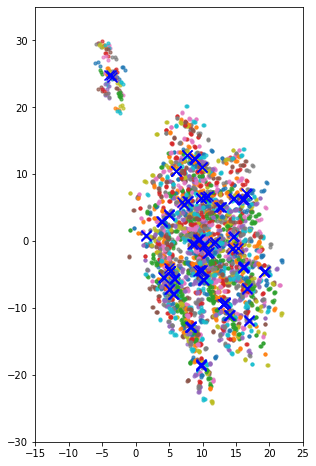

In [2]:
#Open file to save back-projected or source positions
# f_src = open('source_pos.txt', 'w', 0)
# import seaborn as sns
P=len(plummers)
print(P)
N = len(img['x']) #Number of images

defl = np.zeros((2,N,40))
beta = np.zeros((2,N,40))
image = np.zeros(2)
m= [0 for n in range(41)]
m[0]=0
    

factor = 4*G/c**2 #4G/c^2 in cgs
#For loop over images to calculate source positions

fig, ax = plt.subplots(figsize=(8,8))

for j in range(40):
    m[j+1]=plumno['no'][j]+m[j]
    print(j, end='\r')
    
    for k in range(N):
        image[0],image[1]=img['x'][k],img['y'][k]
        D=d_ls[k]/d_ol[k]/d_os[k]
        defl[0,k,j], defl[1,k,j] = 0., 0.
        for i in range(m[j],m[j+1]):
            defl[0,k,j] += factor*m_sol*pmass[i]*D*(image[0]-px[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2 
            defl[1,k,j] += factor*m_sol*pmass[i]*D*(image[1]-py[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2
            beta[0,k,j], beta[1,k,j]=image[0] - defl[0,k,j], image[1] - defl[1,k,j] #lens equation
    ax.scatter(beta[0,:,j],beta[1,:,j],alpha=0.7,s=10)
#     sns.scatterplot(data=beta)

avgbeta=np.average(beta,axis=2)

ax.scatter(avgbeta[0],avgbeta[1],s=100,color='b',marker='x')

ax.set_aspect('equal')
plt.axis([-15,25,-30,35])
# plt.legend(loc='upper right')
plt.show()
        
fig.savefig('Back_Projected_A370_BUFFALO.pdf', dpi=300, transparent=True, bbox_inches='tight')
            

In [3]:
m= [0 for n in range(41)]
umass=np.zeros((40,2),dtype=(int,float))
lmass=np.zeros((40,2),dtype=(int,float))
mass=np.zeros((40,2),dtype=(int,float))
massr=np.zeros((40,1),dtype=(float))

m[0]=0
for i in range(40):
    m[i+1]=plumno['no'][i]+m[i]
#     print(m[i+1])
    umass[i,0]=i+1
    lmass[i,0]=i+1
    mass[i,0]=i+1
#     massr[i,0]=i+1
    
    for j in range(m[i],m[i+1]):
        mass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]<-50:
            lmass[i,1]+=plummers['mass'][j]
        if plummers['y'][j]>50:
            umass[i,1]+=plummers['mass'][j]
        
    massr[i,0]=(umass[i,1]/lmass[i,1])
# mass=list(enumerate(mass))

In [4]:
del_y = np.zeros((len(img['x']),40,2))
# fig, ax = plt.subplots(figsize=(8,8))
for j in range(40): 
    del_y[:,j,0]=j
    del_y[:,j,1]=(beta[1,:,j] - avgbeta[1,:])#/len(img['x'])
# ax.scatter(del_y[0,:,1],del_y[0,:,0])

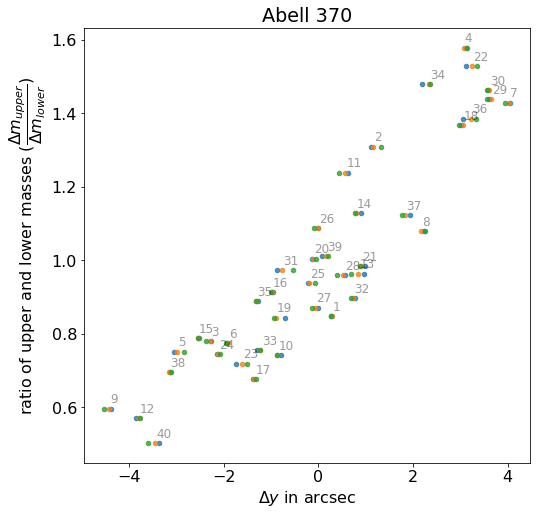

In [12]:
# import pandas as pd

# umass=np.zeros((40,2),dtype=(int,float))

# s=pd.DataFrame(del_y[2,:,1])
# u=pd.DataFrame(massr[0])
# std_y_table=s.sort_values(by=0, ascending=False)
# mass_table=u.sort_values(by=0, ascending=False)

matplotlib.rcParams.update({'font.size': 16})


fig, ax = plt.subplots(figsize=(8,8))

for j in range(40):
    ax.scatter(del_y[0,j,1],massr[j], color='tab:blue', marker='.',s=80,alpha=0.8)
    ax.scatter(del_y[1,j,1],massr[j], color='tab:orange', marker='.',s=80,alpha=0.8)
    ax.scatter(del_y[2,j,1],massr[j], color='tab:green', marker='.',s=80,alpha=0.8)
    ax.annotate(j+1,(del_y[1,j,1],massr[j]),xytext=(del_y[1,j,1]+0.025,massr[j]+0.015),alpha=0.4,fontsize=12)


# plt.scatter(del_y[0,:,1],massr, marker='x')
# plt.scatter(del_y[113,:,1],massr, marker='x')
# plt.scatter(del_y[19,:,1],massr, marker='x')

# z = np.polyfit(del_y[2,:,1], massr, 1)
# xp = np.linspace(0, 10, 100)
# p = np.poly1d(z)
# plt.plot(xp-5, p(xp-5),'g--')

plt.xlabel('$\Delta y$ in arcsec')
plt.ylabel('ratio of upper and lower masses ($\dfrac{\Delta m_{upper}}{\Delta m_{lower}}$)')
# ax.legend(loc='lower right')

plt.title('Abell 370')

plt.show()

fig.savefig('/Users/agnivaghosh/Downloads/Lensing/mag/plots/outermass_A370_src1.pdf', dpi=900, transparent=True,bbox_inches='tight')


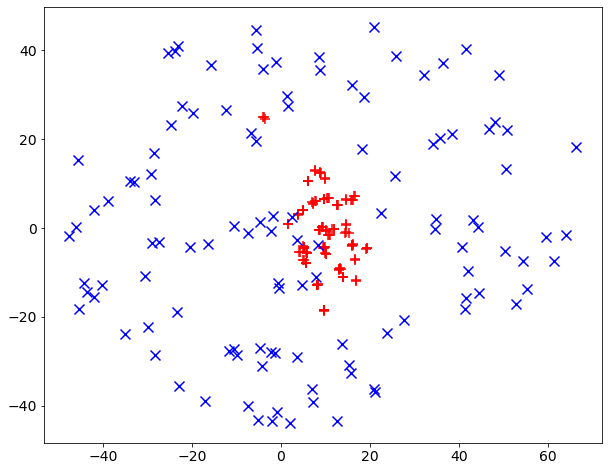

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(avgbeta[0],avgbeta[1],s=100,color='r',marker='+')
ax.scatter(img['x'],img['y'],s=100,color='b',marker='x')

ax.set_aspect('equal')
plt.axis()
plt.show()

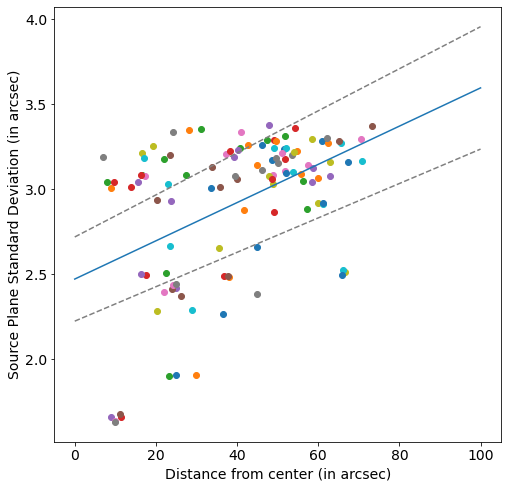

In [7]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
    ax.scatter(np.sqrt((img['y'][i]+20)**2+(img['x'][i]-4)**2),std[i])
    
z = np.polyfit(np.sqrt((img['y']+20)**2+(img['x']-4)**2), std, 1)
xp = np.linspace(0, 100, 100)
p = np.poly1d(z)
plt.plot(xp, p(xp))
plt.plot(xp, 1.1*p(xp),'--',color='gray')
plt.plot(xp, 0.9*p(xp),'--',color='gray')
plt.axis()
# plt.yscale('log')
plt.xlabel("Distance from center (in arcsec)")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()




In [8]:
# z = np.polyfit(np.log10(img['z']), std,3)
z = np.linspace(0.3, 9, 100)
# p = np.poly1d(z)

N=len(z)

#Constants
c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

# Define cosmology.
cosmo = constants(0.3, 0.7, 70)

# Define redshifts
z_o = 0.0  # observer redshift
z_l = 0.375  # lens redshift for Abell 2744

# Initialize angular diameter arrays
d_ol = np.zeros(N)
d_ls = np.zeros(N)
d_os = np.zeros(N)
scrit = np.zeros(N)

d_c, d_M, d_A = 0.0, 0.0, 0.0  # Initialize distances
dist = distances()  # create cosmology.distance instance



# For loop over images to calculate the angular diameter distances and critical surface densities.
for i in range(N):
    z_s = z[i]

    # Calculate the observer to lens ang dist.
    d_c = dist.codist(z_o, z_l, cosmo)
    d_M = dist.tcodist(z_o, z_l, d_c, cosmo)
    d_A = dist.angdist(d_M, z_l, d_A)

    d_ol[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the lens to source ang dist.
    d_c = dist.codist(z_l, z_s, cosmo)
    d_M = dist.tcodist(z_l, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_ls[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the observer to source ang dist.
    d_c = dist.codist(z_o, z_s, cosmo)
    d_M = dist.tcodist(z_o, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_os[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    #Calculate critical surface density
    scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]

<ipython-input-8-8c85d003cd11>:57: RuntimeWarning: divide by zero encountered in double_scalars
  scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]


ValueError: x and y must be the same size

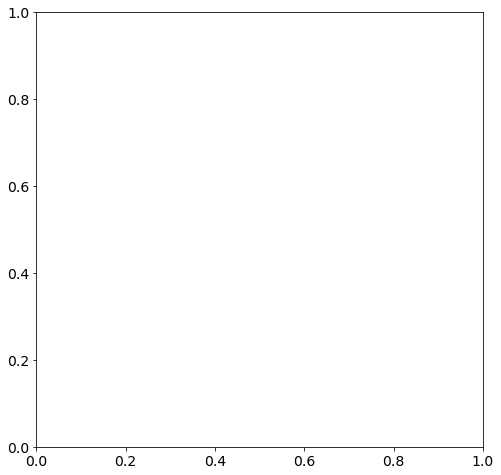

In [9]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
ax.scatter(img['z'],std,color='black',marker='x',label='Total SPsd')
ax.scatter(img['z'],std_src[0,:],color='green',marker='x',label='x SPsd')
ax.scatter(img['z'],std_src[1,:],color='red',marker='x',label='y SPsd')
    
# plt.plot(z, 4*G/c**2*m_sol*d_ls/d_ol/d_os*2.23*10**22)
plt.axis([0.1,10,0,4])
# plt.yscale('log')
plt.xlabel("Redshift")
plt.ylabel("Source Plane Standard Deviation (in arcsec)")
ax.legend(loc='upper right')
plt.show()
fig.savefig('SPsd_xandy_A370_BUFFALO.pdf', dpi=300, transparent=True,bbox_inches='tight')

In [36]:
print(4*(G/c**2)*m_sol*(d_ls/d_ol/d_os))

[0.00000000e+00 5.38887288e-24 3.42568064e-23 5.40051519e-23
 6.83698024e-23 7.92618111e-23 8.77946664e-23 9.46534261e-23
 1.00276632e-22 1.04977551e-22 1.08959832e-22 1.12375350e-22
 1.15333137e-22 1.17924473e-22 1.20210750e-22 1.22242694e-22
 1.24060452e-22 1.25694431e-22 1.27174407e-22 1.28519780e-22
 1.29748196e-22 1.30874366e-22 1.31909508e-22 1.32866419e-22
 1.33752767e-22 1.34576170e-22 1.35342350e-22 1.36058730e-22
 1.36729351e-22 1.37358536e-22 1.37950081e-22 1.38506715e-22
 1.39032662e-22 1.39529899e-22 1.40000767e-22 1.40447359e-22
 1.40871082e-22 1.41274586e-22 1.41658898e-22 1.42025393e-22
 1.42375317e-22 1.42709431e-22 1.43029524e-22 1.43336149e-22
 1.43630165e-22 1.43912045e-22 1.44183152e-22 1.44443825e-22
 1.44694674e-22 1.44936266e-22 1.45168861e-22 1.45393471e-22
 1.45610276e-22 1.45819689e-22 1.46022099e-22 1.46217644e-22
 1.46407105e-22 1.46590569e-22 1.46768327e-22 1.46940460e-22
 1.47107615e-22 1.47269833e-22 1.47427339e-22 1.47580344e-22
 1.47728880e-22 1.478734

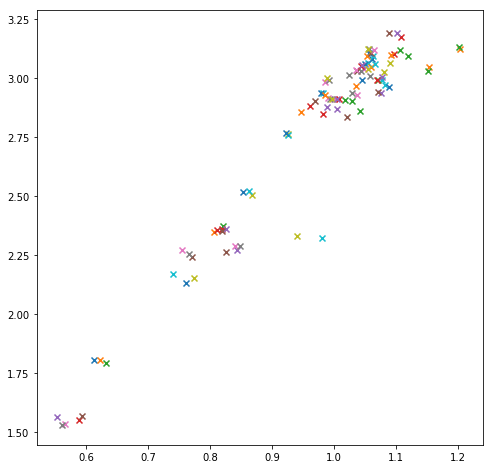

In [258]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(beta[0,i,j] - avgbeta[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(beta[1,i,j] - avgbeta[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(std_src[0,i],std_src[1,i],marker='x')
    
# plt.plot(z, 4*G/c**2*m_sol*d_ls/d_ol/d_os*2.23*10**22)
plt.axis()
# plt.yscale('log')
# plt.xlabel("Redshift")
# plt.ylabel("Source Plane Standard Deviation (in arcsec)")
plt.show()


In [209]:
std

array([0.91460132, 1.37728499, 1.99053615, 1.9617245 , 0.33513126,
       2.96363055, 1.16636773, 0.93645491, 3.08846224, 0.79774581,
       2.32204123, 2.10915839, 2.73460177, 0.22467952, 0.27896943,
       1.69902154, 2.82700105, 2.01531846, 1.53986381, 1.44343245,
       3.49908881, 1.30181303, 2.01467415, 0.46588826, 2.29166915,
       0.72250402, 0.56733664, 0.45827297, 3.18346249, 0.31111894,
       0.32916513, 1.17399253, 1.32135161, 0.6342634 , 1.14965388,
       0.68118305, 0.91805609, 0.30328211, 0.24048897, 0.35479728])

In [210]:
import pandas as pd
s=pd.DataFrame(std)
print(s.sort_values(by=0, ascending=False))
s.dtypes


           0
20  3.499089
28  3.183462
8   3.088462
5   2.963631
16  2.827001
12  2.734602
10  2.322041
24  2.291669
11  2.109158
17  2.015318
22  2.014674
2   1.990536
3   1.961724
15  1.699022
18  1.539864
19  1.443432
1   1.377285
32  1.321352
21  1.301813
31  1.173993
6   1.166368
34  1.149654
7   0.936455
36  0.918056
0   0.914601
9   0.797746
25  0.722504
35  0.681183
33  0.634263
26  0.567337
23  0.465888
27  0.458273
39  0.354797
4   0.335131
30  0.329165
29  0.311119
37  0.303282
14  0.278969
38  0.240489
13  0.224680


0    float64
dtype: object

In [154]:
src_im = np.genfromtxt('../../BUFFALO/Abell370p/back_projected_sources_allim.dat', dtype=(
    {'names': ['tag', 'x', 'y'], 'formats': ['f8', 'f8', 'f8']}))

In [159]:
print(src_im['x']-avgbeta[0])

[ 0.00253168 -0.00166591  0.00176007 -0.00070043  0.00057609  0.00160316
  0.00132044  0.00121089  0.00306111  0.00178675 -0.00291584 -0.00327875
  0.00076135  0.00469071 -0.00033956  0.00096146  0.00146762  0.0018579
  0.00161793  0.0039371  -0.003018    0.00212221  0.00206811  0.00254828
 -0.00547247  0.00584987  0.00431784  0.0054986   0.00491549  0.00172605
 -0.00398762  0.00267783  0.00252484  0.0048181   0.00615122 -0.00632069
  0.00136842  0.00610465 -0.00513884 -0.00381801 -0.00186742  0.00647111
 -0.00039657 -0.00034761 -0.00126799 -0.00449112  0.00620536  0.00060369
  0.0003501   0.0007419  -0.00514925  0.00630583  0.00174697 -0.00532607
  0.00605586 -0.00193577 -0.00447037  0.00640573  0.00036089 -0.00555527
  0.00653223  0.00426142  0.00501188  0.00315972  0.00291695 -0.00353957
 -0.00127082 -0.00455096  0.00619049 -0.0038116   0.00648113 -0.00248195
  0.00518393  0.00567565 -0.00562563  0.00583645 -0.00386324 -0.00138981
  0.00641976 -0.00392726  0.0061553  -0.00019898  0.

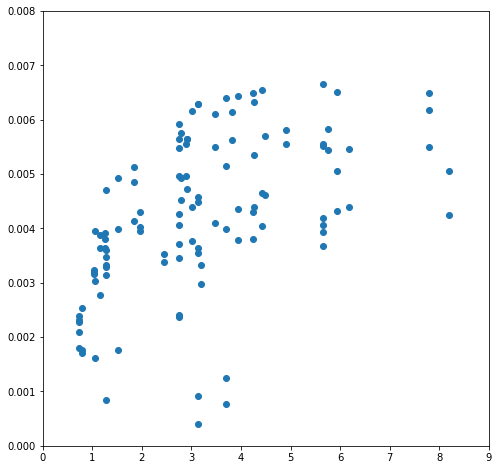

In [173]:
fig, ax = plt.subplots(figsize=(8,8))
dst=np.sqrt((src_im['x']-avgbeta[0])**2+(src_im['y']-avgbeta[1])**2)
ax.scatter(img['z'],dst)
plt.axis([0,9,0,0.008])
plt.show()


In [167]:
print(dst)

[0.00253168 0.00171245 0.00176685 0.00179211 0.00210108 0.00239625
 0.00230882 0.00227892 0.00430106 0.00394966 0.00402286 0.00329396
 0.00084509 0.00470653 0.00314916 0.00333186 0.00347429 0.00360134
 0.0016235  0.00395212 0.00302314 0.00237705 0.00239885 0.00425826
 0.00547818 0.00591778 0.00496621 0.00554395 0.00493032 0.00176233
 0.00399483 0.00371708 0.00346006 0.00549947 0.00617121 0.00649473
 0.00410502 0.0061048  0.00549029 0.00430233 0.00380742 0.0064969
 0.00040172 0.00091613 0.0035463  0.0044914  0.00628679 0.00124465
 0.00398759 0.00076284 0.00515003 0.00639412 0.00439698 0.00535474
 0.00632726 0.00404471 0.00465459 0.00653708 0.00418642 0.00555931
 0.00664723 0.00545055 0.00582769 0.00391555 0.00380343 0.00363842
 0.00364661 0.00457866 0.00628745 0.00505671 0.00651014 0.00431935
 0.00555509 0.00580393 0.00562584 0.00614523 0.00436487 0.00378985
 0.00643802 0.00439829 0.00616015 0.00375885 0.00564297 0.0047162
 0.00564306 0.0046193  0.00569056 0.00551537 0.00405783 0.005454

In [174]:
a=[8.18429243,
          8.19998691,   8.17762284,   8.33679556,   8.31660111]
b=[10.06139111,  10.22749927,
         10.00356977]
print(np.sqrt(np.mean(abs(np.mean(a)-a[:])**2)))
print(np.sqrt(np.mean(abs(np.mean(b)-b[:])**2)))

0.06897186432597009
0.09491496144106529


In [191]:
'''
This could be directly related to fitness values for grale runs? Since they are 
representing the same thing overall.
It might be also related to the amount of focussing in the source plane?
Fitness fo Irtysh I 150 images:
  8    0.00976   0.000000599  159.00000 2250.0
  8    0.00838   0.000000444  158.00000 2250.0
  8    0.01164   0.000000863  157.00000 2250.0
  9    0.00667   0.000000280  159.00000 2550.0
  9    0.01059   0.000000709  158.00000 2550.0
  9    0.01034   0.000000680  157.00000 2550.0
  8    0.00944   0.000000568  157.00000 2250.0
  8    0.01415   0.000001244  161.00000 2250.0
For A370:
  9    0.04257   0.000011692  155.00000 2950.0
  9    0.03603   0.000008890  146.00000 2950.0
  9    0.05314   0.000016325  173.00000 2950.0
  8    0.04961   0.000014649  168.00000 2550.0
  9    0.04697   0.000013054  169.00000 2950.0
  9    0.03878   0.000010516  143.00000 2950.0
  9    0.04166   0.000010645  163.00000 2950.0
  8    0.05566   0.000019361  160.00000 2550.0
  8    0.04997   0.000014520  172.00000 2550.0
''';

## Testing z dependence

114976


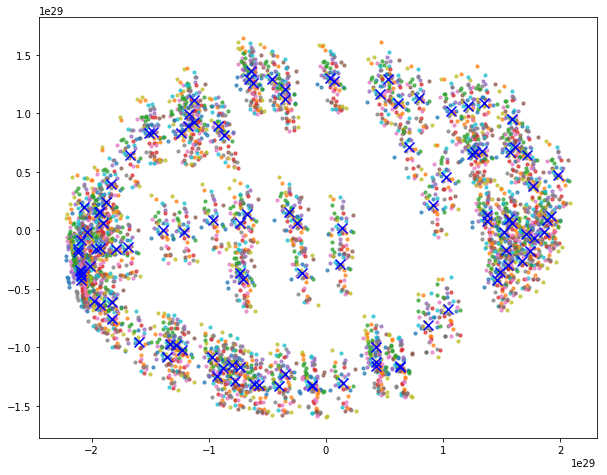

In [32]:
#Open file to save back-projected or source positions
# f_src = open('source_pos.txt', 'w', 0)
# import seaborn as sns
P=len(plummers)
print(P)
N = len(img['x']) #Number of images

defl = np.zeros((2,N,40))
beta = np.zeros((2,N,40))
image = np.zeros(2)
m= [0 for n in range(41)]
m[0]=0
    

factor = 4*G/c**2 #4G/c^2 in cgs
#For loop over images to calculate source positions

fig, ax = plt.subplots(figsize=(10, 10))
import time
for j in range(40):
    m[j+1]=plumno['no'][j]+m[j]
    print (j, end="\r")
    
    for k in range(N):
        image[0],image[1]=img['x'][k],img['y'][k]
        D=d_ls[k]/d_ol[k]/d_os[k]
        defl[0,k,j], defl[1,k,j] = 0., 0.
#         defl[0,k,j] = np.average(factor*m_sol*pmass[i]*D*(image[0]-px[:])/((image[0]-px[:])**2+(image[1]-py[:])**2+(pwidth[:])**2)*rad_arcs**2) 
#         defl[1,k,j] = np.average(factor*m_sol*pmass[i]*D*(image[1]-py[:])/((image[0]-px[:])**2+(image[1]-py[:])**2+(pwidth[:])**2)*rad_arcs**2)

        for i in range(m[j],m[j+1]):
            defl[0,k,j] += factor*m_sol*pmass[i]*(image[0]-px[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2 
            defl[1,k,j] += factor*m_sol*pmass[i]*(image[1]-py[i])/((image[0]-px[i])**2+(image[1]-py[i])**2+(pwidth[i])**2)*rad_arcs**2
        beta[0,k,j], beta[1,k,j]=image[0] - defl[0,k,j], image[1] - defl[1,k,j] #lens equation
    ax.scatter(defl[0,:,j],defl[1,:,j],alpha=0.7,s=10)
#     sns.scatterplot(data=beta)

avgdefl=np.average(defl,axis=2)

ax.scatter(avgdefl[0],avgdefl[1],s=100,color='b',marker='x')
ax.set_aspect('equal')

plt.axis()
# plt.legend(loc='upper right')
plt.show()
        
            
            

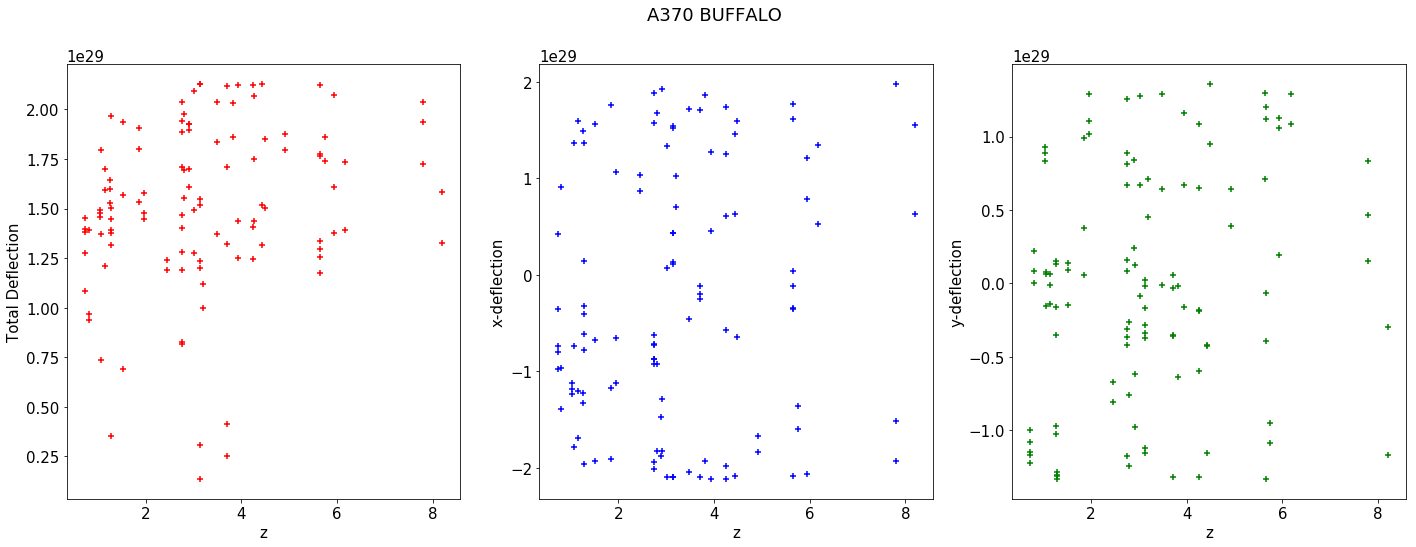

In [36]:
std=np.zeros(N)
plt.rcParams.update({'font.size': 15})
z=img['z']
avgdefl=np.average(defl,axis=2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24,8))
fig.suptitle('A370 BUFFALO')
ax1.scatter(z,np.sqrt(avgdefl[0]**2+avgdefl[1]**2),c='r',marker='+')
ax1.set(xlabel='z', ylabel='Total Deflection')
ax2.scatter(z,avgdefl[0],c='b',marker='+')
ax2.set(xlabel='z', ylabel='x-deflection')
ax3.scatter(z,avgdefl[1],c='g',marker='+')
ax3.set(xlabel='z', ylabel='y-deflection')

plt.show()


            2
-8.202e+26 x + 6.833e+26 x + 1.309e+28


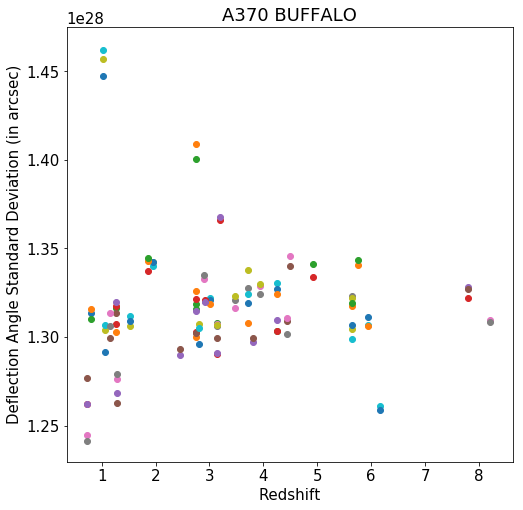

In [39]:
std_src = np.zeros((2,N))
std=np.zeros(N)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(N): 
    for j in range(40): 
        std_src[0,i]+=np.sqrt(abs(defl[0,i,j] - avgdefl[0,i])**2)/40
        std_src[1,i]+=np.sqrt(abs(defl[1,i,j] - avgdefl[1,i])**2)/40
    std[i]=np.sqrt(std_src[0,i]**2+std_src[1,i]**2)
#     print(std[i],img['z'][i])
    ax.scatter(img['z'][i],std[i])
    
z = np.polyfit(np.log10(img['z']), std,2)
xp = np.linspace(0.3, 8, 100)
p = np.poly1d(z)
print(p)
# plt.plot(xp, p(np.log10(xp)))
plt.axis()
# plt.yscale('log')
plt.title("A370 BUFFALO")
plt.xlabel("Redshift")
plt.ylabel("Deflection Angle Standard Deviation (in arcsec)")
plt.show()

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
mass = np.genfromtxt('/Users/agnivaghosh/Downloads/Lensing/BUFFALO/Abell370p/mass.dat', dtype=(
    {'names': ['x', 'y', 'mass'], 'formats': ['f8', 'f8', 'f8']}))

N=np.sqrt(len(mass['mass']))
print(N)

360.0


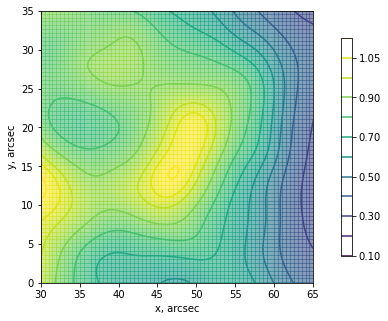

In [2]:


x = np.linspace(-75, 105, 360)
y = np.linspace(-90, 90, 360)
X, Y = np.meshgrid(x, y)
Z1=(abs(mass['mass'])).reshape(360,360)
# Z2=(abs(muavgsum)).reshape(N,N)

fig, ax0 = plt.subplots(figsize=(10, 5))


im=ax0.pcolormesh(X,Y,Z1/3.13924,vmax=1.1,cmap='viridis',shading='auto',alpha=0.6)
im1=ax0.contour(X,Y,Z1/3.13924,[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.05,1.1],cmap='viridis',alpha=1)

fig.colorbar(im1, ax=ax0,shrink=0.8)

# fig.colorbar(im2, ax=ax1)
ax0.axis([30,65,0,35])
# ax1.axis([-10,30,-30,30])
ax0.set_aspect('equal')
# ax1.set_aspect('equal')
# plt.title("A370 BUFFALO")
plt.xlabel("x, arcsec")
plt.ylabel("y, arcsec")
plt.show()
fig.savefig('/Users/agnivaghosh/Downloads/Lensing/mag/plots/Massmap_A370_BUFFALO_subs.png', dpi=300, transparent=True, bbox_inches='tight')

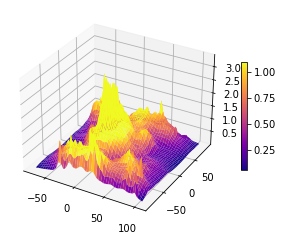

In [10]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()

ax=fig.add_subplot(projection='3d')

im=ax.plot_surface(X,Y,Z1/3.13924, cmap='plasma',vmax=1.1)
fig.colorbar(im, ax=ax, shrink=0.5)
# ax.set_aspect('equal')
# ax.set_title('3D True Mass ')
# ax.set_xlim3d(30,65)
# ax.set_ylim3d(0,35)


plt.show()

In [110]:
nmass=0
tmass=0
allmass=0
k=0
m_sol = 1.989e30 #Solar mass in grams
for j in range(len(mass['mass'])):
#         mass[i,1]+=mass['mass'][j]
        allmass+=mass['mass'][j]
        if mass['y'][j]<25 and mass['y'][j]>7.5 and mass['x'][j]<55 and mass['x'][j]>40:
            tmass+=mass['mass'][j]
            nmass+=0.7*3.13924
            k+=1

In [112]:
tmass/(35*30
      )

2.9673665190476206

In [103]:
tmass=(tmass/m_sol)*0.25*(5.1487*3.086*10**19)**2
nmass=(nmass/m_sol)*0.25*(5.1487*3.086*10**19)**2
allmass=(allmass/m_sol)*0.25*(5.1487*3.086*10**19)**2

In [104]:
print(tmass,nmass,tmass/nmass,tmass-nmass)

9886731393122.688 7321568037357.075 1.3503571014675129 2565163355765.6123


In [105]:
180*180/(17.5*15)

123.42857142857143

In [106]:
print(allmass)

885609642814375.2


In [107]:
print('the difference in mass is',tmass-nmass)

the difference in mass is 2565163355765.6123
